In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # noqa: E402
import numpy as np
import seaborn as sns
import pandas as pd

flist = matplotlib.font_manager.get_font_names()
from pathlib import Path  # noqa: E402

from extremeweatherbench import cases, defaults, evaluate, regions  # noqa: E402

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

# ugly hack to load in our plotting scripts
# import sys  # noqa: E402

#sys.path.append(basepath + "/docs/notebooks/")
import src.plots.plotting_utils as plot_utils  # noqa: E402
import src.plots.results_utils as results_utils  # noqa: E402
import src.plots.plotting_styles as ps  # noqa: E402


In [3]:
# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()
# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources
# to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [4]:
# to plot the targets, we need to run the pipeline for each case and target
from joblib import Parallel, delayed  # noqa: E402
from joblib.externals.loky import get_reusable_executor  # noqa: E402

# load in all the case info (note this takes awhile in non-parallel form as it has to
# run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

print("running the pipeline for each case and target")
parallel = Parallel(n_jobs=32, return_as="generator", backend="loky")
case_operators_with_targets_established_generator = parallel(
    delayed(
        lambda co: (
            co.case_metadata.case_id_number,
            evaluate.run_pipeline(co.case_metadata, co.target),
        )
    )(case_operator)
    for case_operator in case_operators
)
case_operators_with_targets_established = list(
    case_operators_with_targets_established_generator
)
# this will throw a bunch of errors below but they're not consequential. this releases
# the memory as it shuts down the workers
get_reusable_executor().shutdown(wait=True)


running the pipeline for each case and target


/home/amy/extreme-weather-bench-paper/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [7]:
# load the results back in
pang_heat_results = pd.read_pickle(basepath + 'saved_data/bb_pangu_heat_results.pkl')
hres_heat_results = pd.read_pickle(basepath + 'saved_data/hres_heat_results.pkl')
gc_heat_results = pd.read_pickle(basepath + 'saved_data/bb_graphcast_heat_results.pkl')
aifs_heat_results = pd.read_pickle(basepath + 'saved_data/bb_aifs_heat_results.pkl')

pang_freeze_results = pd.read_pickle(basepath + 'saved_data/bb_pangu_freeze_results.pkl')
hres_freeze_results = pd.read_pickle(basepath + 'saved_data/hres_freeze_results.pkl')
gc_freeze_results = pd.read_pickle(basepath + 'saved_data/bb_graphcast_freeze_results.pkl')
aifs_freeze_results = pd.read_pickle(basepath + 'saved_data/bb_aifs_freeze_results.pkl')

pang_severe_results = pd.read_pickle(basepath + 'saved_data/bb_pangu_severe_results.pkl')
hres_severe_results = pd.read_pickle(basepath + 'saved_data/hres_severe_results.pkl')
gc_severe_results = pd.read_pickle(basepath + 'saved_data/bb_graphcast_severe_results.pkl')
aifs_severe_results = pd.read_pickle(basepath + 'saved_data/bb_aifs_severe_results.pkl')


In [ ]:
# plot ERA5 versus GHCN for IFS
gc_bb_ifs_ghcn = ps.gc_bb_ifs_settings | ps.ghcn_group_style
pangu_bb_ifs_ghcn = ps.pangu_bb_ifs_settings | ps.ghcn_group_style
aifs_bb_ifs_ghcn = ps.aifs_ifs_settings | ps.ghcn_group_style
hres_ghcn = ps.hres_ifs_settings | ps.ghcn_group_style

gc_bb_ifs_era5 = ps.gc_bb_ifs_settings | ps.era5_group_style
pangu_bb_ifs_era5 = ps.pangu_bb_ifs_settings | ps.era5_group_style
aifs_bb_ifs_era5 = ps.aifs_ifs_settings | ps.era5_group_style
hres_era5 = ps.hres_ifs_settings | ps.era5_group_style

lead_time_days = [1, 3, 5, 7, 10]

# subset the data for the plots
gc_heat_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_bb_ifs_ghcn['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
pangu_heat_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_bb_ifs_ghcn['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
aifs_heat_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=aifs_heat_results, 
    forecast_source=aifs_bb_ifs_ghcn['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
hres_heat_ghcn_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_ghcn['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)


gc_heat_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=gc_heat_results, 
    forecast_source=gc_bb_ifs_ghcn['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
pangu_heat_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=pang_heat_results, 
    forecast_source=pangu_bb_ifs_ghcn['forecast_source'],
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
aifs_heat_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=aifs_heat_results, 
    forecast_source=aifs_bb_ifs_ghcn['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
hres_heat_era5_plot = results_utils.subset_results_to_xarray(results_df=hres_heat_results, 
    forecast_source=hres_ghcn['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)

# setup to plot the results
heat_data = [gc_heat_ifs_ghcn_plot, gc_heat_ifs_era5_plot, 
    pangu_heat_ifs_ghcn_plot, pangu_heat_ifs_era5_plot, 
    aifs_heat_ifs_ghcn_plot, aifs_heat_ifs_era5_plot, 
    hres_heat_ghcn_plot, hres_heat_era5_plot]
heat_settings = [gc_bb_ifs_ghcn, gc_bb_ifs_ghcn, pangu_bb_ifs_ghcn, pangu_bb_ifs_era5,
    aifs_bb_ifs_ghcn, aifs_bb_ifs_era5, hres_ghcn, hres_era5]

# grab the freeze results
gc_freeze_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=gc_freeze_results, 
    forecast_source=gc_bb_ifs_ghcn['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
pangu_freeze_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=pang_freeze_results, 
    forecast_source=pangu_bb_ifs_ghcn['forecast_source'],
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
aifs_freeze_ifs_ghcn_plot = results_utils.subset_results_to_xarray(results_df=aifs_freeze_results, 
    forecast_source=aifs_bb_ifs_ghcn['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
hres_freeze_ghcn_plot = results_utils.subset_results_to_xarray(results_df=hres_freeze_results, 
    forecast_source=hres_ghcn['forecast_source'], 
    target_source='GHCN', metric='RootMeanSquaredError', lead_time_days=lead_time_days)

gc_freeze_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=gc_freeze_results, 
    forecast_source=gc_bb_ifs_ghcn['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
pangu_freeze_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=pang_freeze_results, 
    forecast_source=pangu_bb_ifs_ghcn['forecast_source'],
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)
hres_freeze_era5_plot = results_utils.subset_results_to_xarray(results_df=hres_freeze_results, 
    forecast_source=hres_ghcn['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days) 
aifs_freeze_ifs_era5_plot = results_utils.subset_results_to_xarray(results_df=aifs_freeze_results, 
    forecast_source=aifs_bb_ifs_ghcn['forecast_source'], 
    target_source='ERA5', metric='RootMeanSquaredError', lead_time_days=lead_time_days)


# plot the results
freeze_data = [gc_freeze_ifs_ghcn_plot, gc_freeze_ifs_era5_plot, 
    pangu_freeze_ifs_ghcn_plot, pangu_freeze_ifs_era5_plot, 
    aifs_freeze_ifs_ghcn_plot, aifs_freeze_ifs_era5_plot, 
    hres_freeze_ghcn_plot, hres_freeze_era5_plot]
freeze_settings = [gc_bb_ifs_ghcn, gc_bb_ifs_ghcn, pangu_bb_ifs_ghcn, pangu_bb_ifs_era5,
    aifs_bb_ifs_ghcn, aifs_bb_ifs_era5, hres_ghcn, hres_era5]



{'forecast_source': 'BB AIFS', 'label_str': 'AIFS', 'color': '#B2B24D', 'linestyle': '--', 'marker': 's', 'group': 'ERA5'}


In [ ]:
gc_gfs_era5_settings_tp  = ps.gc_bb_ifs_settings | ps.gc_style | ps.severe_tp_settings 
pangu_gfs_era5_settings_tp = ps.pangu_bb_ifs_settings | ps.pangu_style | ps.severe_tp_settings 
hres_era5_settings_tp = ps.hres_ifs_settings | ps.hres_style | ps.severe_tp_settings 
aifs_era5_settings_tp = ps.aifs_ifs_settings | ps.aifs_bb_settings | ps.severe_tp_settings 

# grab the severe results
gc_severe_plot_tp = results_utils.subset_results_to_xarray(results_df=gc_severe_results, 
    forecast_source=gc_gfs_era5_settings_tp['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', lead_time_days=lead_time_days)
pangu_severe_plot_tp  = results_utils.subset_results_to_xarray(results_df=pang_severe_results, 
    forecast_source=pangu_gfs_era5_settings_tp['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', lead_time_days=lead_time_days)
hres_severe_plot_tp = results_utils.subset_results_to_xarray(results_df=hres_severe_results, 
    forecast_source=hres_era5_settings_tp['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', lead_time_days=lead_time_days)
aifs_severe_plot_tp = results_utils.subset_results_to_xarray(results_df=aifs_severe_results, 
    forecast_source=aifs_era5_settings_tp['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', lead_time_days=lead_time_days)

# plot the results
severe_data_tp = [gc_severe_plot_tp, pangu_severe_plot_tp, hres_severe_plot_tp, aifs_severe_plot_tp]
severe_settings_tp = [gc_gfs_era5_settings_tp, pangu_gfs_era5_settings_tp, hres_era5_settings_tp, aifs_era5_settings_tp]


gc_gfs_era5_settings_fn  = ps.gc_gfs_cira_settings | ps.gc_style | ps.severe_fn_settings 
pangu_gfs_era5_settings_fn = ps.pangu_gfs_cira_settings | ps.pangu_style | ps.severe_fn_settings 
hres_era5_settings_fn = ps.hres_ifs_settings | ps.hres_style | ps.severe_fn_settings 
aifs_era5_settings_fn = ps.aifs_ifs_settings | ps.aifs_bb_settings | ps.severe_fn_settings 

# grab the results for the false negatives
gc_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=gc_severe_results, 
    forecast_source=gc_gfs_era5_settings_fn['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', lead_time_days=lead_time_days)
pangu_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=pang_severe_results, 
    forecast_source=pangu_gfs_era5_settings_fn['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', lead_time_days=lead_time_days)
hres_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=hres_severe_results, 
    forecast_source=hres_era5_settings_fn['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', lead_time_days=lead_time_days)
aifs_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=aifs_severe_results, 
    forecast_source=aifs_era5_settings_fn['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', lead_time_days=lead_time_days)

# plot the results
severe_data_fn = [gc_severe_plot_fn, pangu_severe_plot_fn, hres_severe_plot_fn, aifs_severe_plot_fn]
severe_settings_fn = [gc_gfs_era5_settings_fn, pangu_gfs_era5_settings_fn, hres_era5_settings_fn, aifs_era5_settings_fn]

[{'forecast_source': 'CIRA GC GFS', 'label_str': 'GraphCast', 'color': '#A15A7E', 'linestyle': '-', 'marker': 'o', 'group': 'True Positives'}, {'forecast_source': 'CIRA PANG GFS', 'label_str': 'Pangu Weather', 'color': '#CC4A4A', 'linestyle': '-', 'marker': 'o', 'group': 'True Positives'}, {'forecast_source': 'ECMWF HRES', 'label_str': 'HRES', 'color': 'black', 'linestyle': '-', 'marker': 'o', 'group': 'True Positives'}, {'forecast_source': 'BB AIFS', 'label_str': 'AIFS', 'color': '#B2B24D', 'linestyle': '-', 'marker': 'o', 'group': 'True Positives'}]


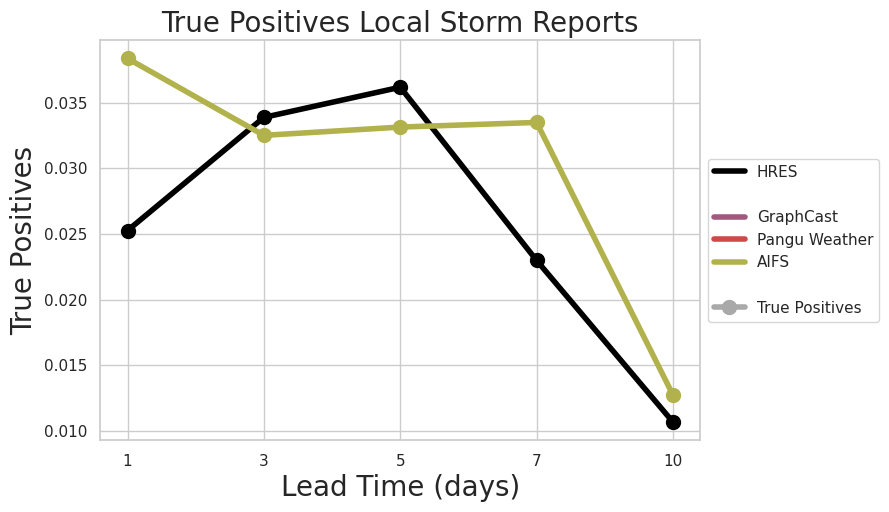

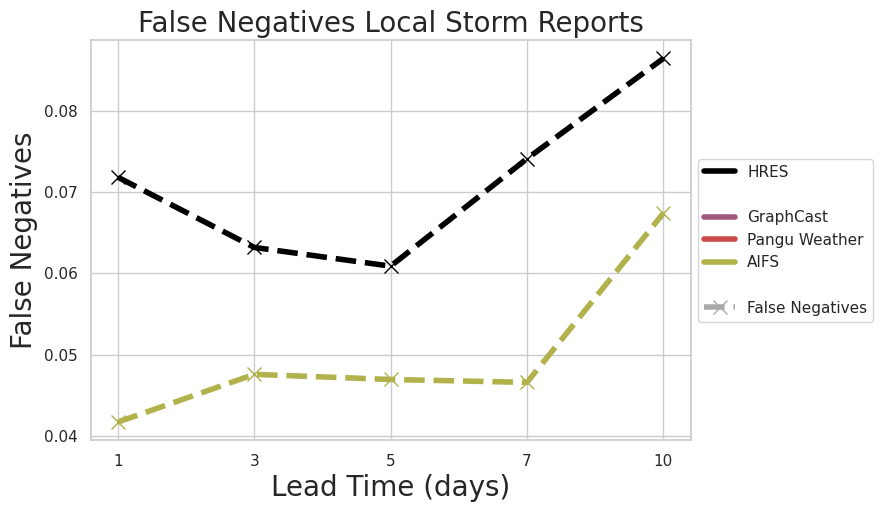

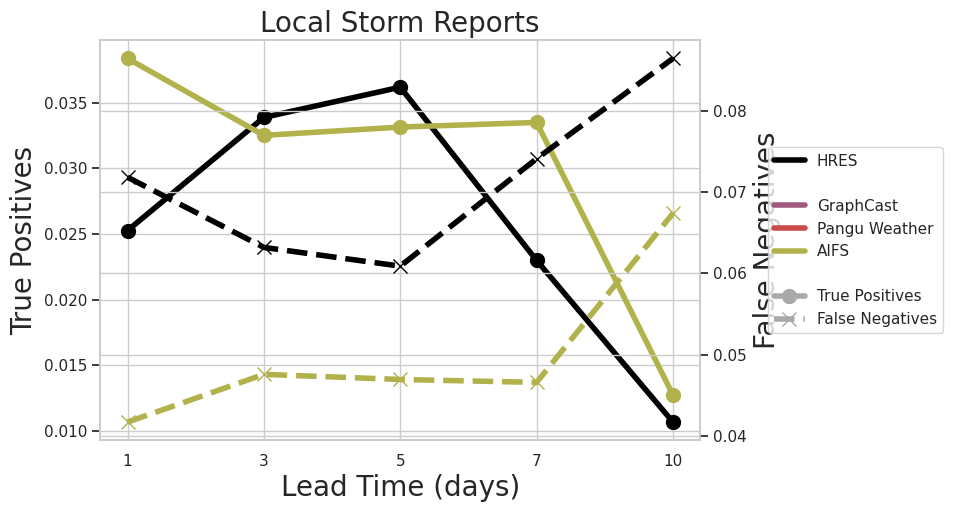

In [14]:
print(severe_settings_tp)
plot_utils.plot_results_by_metric(data=severe_data_tp, settings=severe_settings_tp, 
    title='True Positives Local Storm Reports', show_all_in_legend=False, y_label='True Positives')
plot_utils.plot_results_by_metric(data=severe_data_fn, settings=severe_settings_fn, 
    title='False Negatives Local Storm Reports', show_all_in_legend=False, y_label='False Negatives')
plot_utils.plot_two_results_by_metric(data1=severe_data_tp, data2=severe_data_fn, 
    settings1=severe_settings_tp, settings2=severe_settings_fn, 
    y_label1='True Positives', y_label2='False Negatives',
    title='Local Storm Reports', show_all_in_legend=False)


In [ ]:
from matplotlib.gridspec import GridSpec

n_rows = 5
n_cols = 3
figsize = (7.5 * n_cols, 4 * n_rows)
print(figsize)

# Create figure first
fig = plt.figure(figsize=figsize)

# Use GridSpec for better control over subplot sizes, especially with mixed cartopy/regular subplots
# Make column 2 wider for line plots (width_ratios: col0, col1, col2)
# Use negative hspace to compress vertical spacing (negative values allow overlap)
gs = GridSpec(n_rows, n_cols, figure=fig, 
              left=0.05, right=0.95, top=0.98, bottom=0.02,
              wspace=0.15, hspace=0.3,  
              width_ratios=[1, 1, 1.5])  # Make column 2 (index 2) 1.5x wider

# Create a grid of subplots - specify which ones should use cartopy
# Example: cartopy_subplots = [(0, 0), (1, 0)] means rows 0,1 in column 0 use cartopy
# You can modify this list to specify which subplots need cartopy projections
cartopy_subplots = [(0,0), (1,0), (2,0), (3,0), (4,0), (0,1), (1,1), (2,1), (3,1), (4,1)]  # Add tuples like (row, col) for subplots that need cartopy

# Create all subplots
axs = []
for i in range(n_rows):
    row = []
    for j in range(n_cols):
        if (i, j) in cartopy_subplots:
            # Create cartopy subplot
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        else:
            # Create regular matplotlib subplot
            ax = fig.add_subplot(gs[i, j])
        row.append(ax)
    axs.append(row)

# Convert to numpy array for easier indexing (matching plt.subplots behavior)
axs = np.array(axs)

# the left hand column of figure one shows all of the cases for each event type
# plot the cases for each event type
print("plotting the cases for each event type")
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="heat_wave",
    fill_boxes=True,
    ax=axs[0, 0],
)
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="freeze",
    fill_boxes=True,
    ax=axs[1, 0],
)
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="tropical_cyclone",
    fill_boxes=True,
    ax=axs[2, 0],
)
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="severe_convection",
    fill_boxes=True,
    ax=axs[3, 0],
)
plot_utils.plot_all_cases(
    ewb_cases,
    event_type="atmospheric_river",
    fill_boxes=True,
    ax=axs[4, 0],
)

# the next column of figure one shows the cases for each event type with the obs
# plot the cases for each event type with the observations
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="heat_wave",
    targets=case_operators_with_targets_established,
    ax=axs[0, 1],
)
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="freeze",
    targets=case_operators_with_targets_established,
    ax=axs[1, 1],
)
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="tropical_cyclone",
    targets=case_operators_with_targets_established,
    ax=axs[2, 1],
)
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    ax=axs[3, 1],
)
# pp.plot_all_cases_and_obs(
#     ewb_cases,
#     event_type="atmospheric_river",
#     targets=case_operators_with_targets_established,
#     ax=axs[4, 1],
# )

# the next column of figure 1 shows how useful the target obs are for each event
plot_utils.plot_results_by_metric(data=heat_data, settings=heat_settings, 
    title='RMSE Global Heat Waves ERA5/GHCN', show_all_in_legend=False, ax=axs[0,2])

plot_utils.plot_results_by_metric(data=freeze_data, settings=freeze_settings, 
    title='RMSE Global Freezes ERA5/GHCN', show_all_in_legend=False, ax=axs[1,2])

plot_utils.plot_results_by_metric(data=severe_data_tp, settings=severe_settings_tp, 
    title='True Positives Local Storm Reports', show_all_in_legend=False, ax=axs[3,2], 
    y_label='True Positives')


# for now,  dont show the TC data and nothing for ARs 
axs[2,2].axis('off')
axs[4,1].axis('off')
axs[4,2].axis('off')

# fig.savefig(basepath + "saved_data/figure1.png", dpi=600)